## Table of Contents
1. [Introduction](#introduction)
2. [Setup](#setup)
3. [Data Loading](#data-loading)
4. [Data Selection](#data-selection)
5. [Photometry Loading and Transformation](#photometry-loading-and-transformation)
6. [Gaussian Process Application](#gaussian-process-application)
7. [Data Standardization](#data-standardization)
8. [Visualizations of Gaussian Processes](#visualizations-of-gaussian-processes)
9. [Data Preparation for Modeling](#data-preparation-for-modeling)
10. [Data Augmentation](#data-augmentation)
11. [Model Construction](#model-construction)
12. [Model Compilation](#model-compilation)
13. [Model Training](#model-training)
14. [Loading the Best Model](#loading-the-best-model)
15. [Testing on Test Data](#testing-on-test-data)
16. [Evaluation and Visualization](#evaluation-and-visualization)
    - [Classification Report](#classification-report)
    - [ROC Curve](#roc-curve)
    - [Confusion Matrix](#confusion-matrix)
    - [Accuracy per Class](#accuracy-per-class)
    - [Early Classification Trade-Off](#early-classification-trade-off)
17. [Testing on New Data](#testing-on-new-data)
18. [Conclusion](#conclusion)

## Introduction

The goal of this project is to develop a model that classifies types of supernovae based on their light curves, specifically focusing on photometric data. The task at hand is to distinguish between two primary types of supernovae: Type I (SN I) and Type II (SN II) through binary classification.

This study draws inspiration from a research paper which explores advanced preprocessing methods for constructing light curves using Gaussian processes. The paper, which can be accessed [here](https://arxiv.org/abs/2105.06178), details the use of Gaussian processes to smooth and interpolate the raw photometric data, thereby facilitating better feature extraction for subsequent classification tasks.

The model we intend to build, referred to as "T2", is based on the transformer architecture.In this project, we leverage the transformer model to process the time-series data derived from the light curves of supernovae, aiming to efficiently classify these astronomical events into their respective types.

## Setup

In [1]:
!pip install george

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.9/378.9 kB 7.8 MB/s eta 0:00:00:00:01


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tqdm as tqdm
import random
import os
import json
import numpy as np

import george
from functools import partial
import scipy.optimize as op
from astropy.table import Table, vstack

## Data Loading

In [2]:
DATA_DIRECTORY = "/media/theob/E/ML_project_data/data"
bts_path = '../BTS.csv'

df = pd.read_csv(bts_path)
df.rename(columns={'ZTFID': 'objectId'}, inplace=True)
df

,objectId,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
0,ZTF17aaaeqms,AT2023jkf,01:19:13.43,+31:46:26.1,2102.97,r,17.5839,-,18.001,12.004,5.997,-,-,-30.726791,0.205
1,ZTF17aaajowi,-,11:47:44.37,+14:34:10.4,1362.73,r,18.9963,-,>5.611,2.651,>2.96,-,-,70.564727,0.127
2,ZTF17aaanztg,AT2021abaw,10:04:06.59,-01:12:18.6,1501.02,r,18.3035,-,>14.737,>3,11.737,-,-,40.798120,0.210
3,ZTF17aaaocnx,AT2019dlf,06:12:54.20,+48:49:57.0,584.70,g,17.2290,-,6.213,0.803,5.41,-,-,14.194943,0.407
4,ZTF17aaaptxx,AT2023gdf,11:54:24.96,+09:36:32.8,2053.73,g,18.9437,-,>2,>2,>0,-,-,67.910221,0.079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14148,ZTF24aaguphd,AT2024ega,16:28:11.53,+47:28:46.5,2383.91,r,18.6175,-,>0,>0,>0,-,-,43.474263,0.049
14149,ZTF24aagwfly,AT2024dit,05:19:17.35,+01:19:26.3,2378.65,r,18.4562,-,>0.02,>0,>0.02,-,-,-19.733640,0.381
14150,ZTF24aagwwkr,AT2024ean,08:06:03.89,+00:37:40.3,2378.69,g,18.3445,-,>0.02,>0,>0.02,-,-,16.839103,0.093
14151,ZTF24aagzzye,AT2024ebu,16:59:07.45,+77:03:24.3,2379.87,g,18.3306,-,>0.04,>0.04,>0,-,-,32.563154,0.101


In [3]:
def plot_types_distributions(data, form='bar'):

    if form not in ['bar', 'pie']:
        print('Invalid form, please choose between bar and pie')
        return
    
    count = data['type'].value_counts()

    plt.figure(figsize=(10, 6))
    plt.title('Distribution of Types')
    plt.ylabel('Types')
    plt.xlabel('Count')

    if form == 'bar':
        count.plot(kind='bar')
        for i, v in enumerate(count):
            plt.text(i, v, str(v), ha='center', rotation=45, fontsize=10)
    else:
        count.plot(kind='pie', autopct='%1.1f%%', shadow=True)

    plt.show()

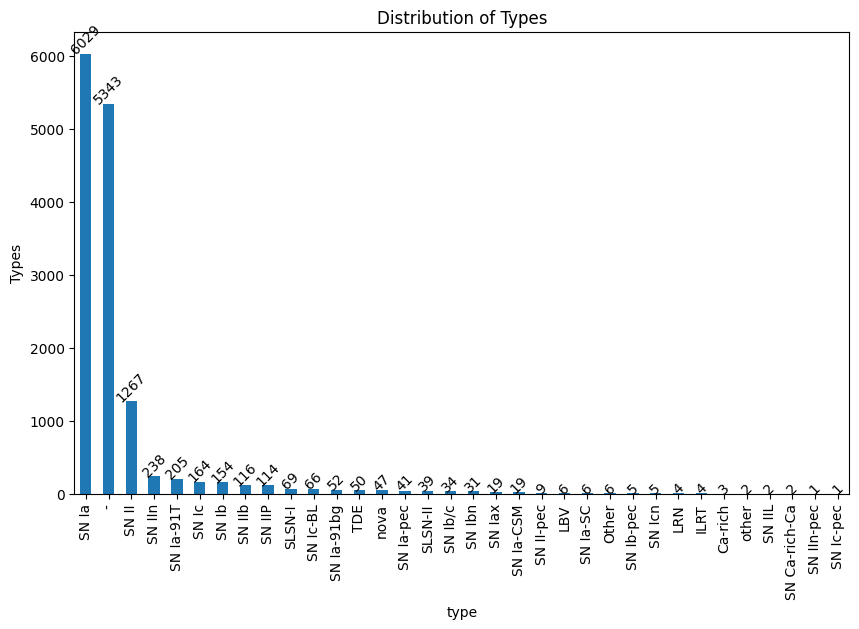

In [4]:
plot_types_distributions(df)

## Data Selection

In [5]:
def categorize_type(event_type):
    if 'SN II' in event_type:
        return 'SN II'
    elif 'SN I' in event_type:
        return 'SN I'
    else:
        return 'Other'

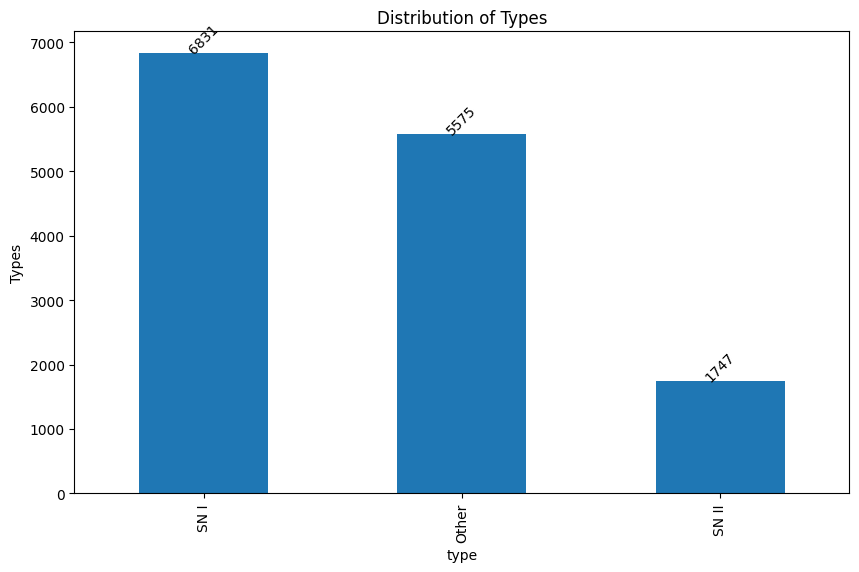

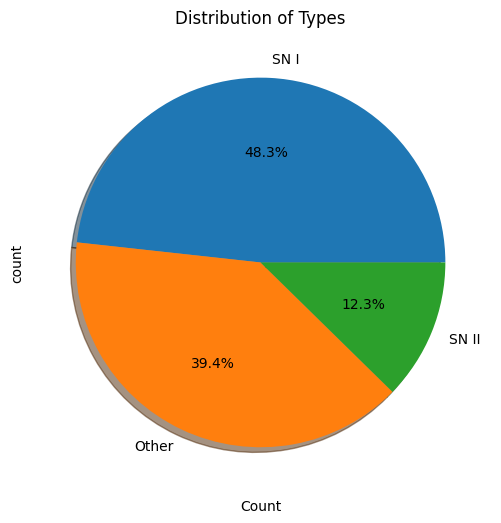

In [6]:
df['type'] = df['type'].apply(categorize_type)
plot_types_distributions(df)
plot_types_distributions(df, form='pie')

## Photometry Loading and Transformation

In [ ]:
def load_all_photometry(df, dataDir=DATA_DIRECTORY, save=False):
    res_df = pd.DataFrame()
    for obj_id in tqdm.tqdm(df['objectId']):
        try:
            objDirectory = os.path.join(dataDir, obj_id)
            photometryFile = os.path.join(objDirectory, 'photometry.json')
            with open(photometryFile) as f:
                photometry = json.load(f)

            photometry_df = pd.DataFrame(photometry)            
            photometry_df = photometry_df[['obj_id', 'mjd', 'mag', 'magerr', 'snr', 'limiting_mag', 'filter']]
            
            type_obj = df[df['objectId'] == obj_id]['type'].values[0]
            photometry_df['type'] = type_obj
            
            res_df = pd.concat([res_df, photometry_df])
        except Exception as e:
            print(f"Failed for {obj_id}: {e}")
            continue

    res_df.reset_index(drop=True, inplace=True)

    if save:
        types_str = '_'.join(df['type'].unique()) if hasattr(df['type'].unique(), '__iter__') else str(df['type'].unique())
        filename = f'photometry_{types_str}.csv'
        filename = filename.replace(' ', '_')
        res_df.to_csv(filename, index=False)
        print(f'File {filename} saved successfully')

    return res_df

In [7]:
#photo_df = load_all_photometry(df, save=True)

photo_df = pd.read_csv('../photometry_Other_SN_I_SN_II.csv')
photo_df

,obj_id,mjd,mag,magerr,snr,limiting_mag,filter,type
0,ZTF17aaaeqms,60081.478391,NaN,NaN,NaN,18.918100,ztfr,Other
1,ZTF17aaaeqms,60081.480752,NaN,NaN,NaN,19.038200,ztfr,Other
2,ZTF17aaaeqms,60081.483125,NaN,NaN,NaN,18.864799,ztfr,Other
3,ZTF17aaaeqms,60081.485486,NaN,NaN,NaN,18.842501,ztfr,Other
4,ZTF17aaaeqms,60081.487859,NaN,NaN,NaN,18.709999,ztfr,Other
...,...,...,...,...,...,...,...,...
4118620,ZTF24aahdisu,60389.506169,18.818848,0.093825,11.571978,19.729942,ztfr,Other
4118621,ZTF24aahdisu,60389.506169,18.818800,0.093825,11.571929,19.729889,ztfr,Other
4118622,ZTF24aahdisu,60389.506169,18.791941,0.032035,33.892427,20.869772,ztfr,Other
4118623,ZTF24aahdisu,60391.263009,NaN,NaN,NaN,18.093500,ztfr,Other


In [8]:
photo_df = photo_df[photo_df['filter'].isin(['ztfg', 'ztfr', 'ztfi'])]
photo_df.dropna(inplace=True)
photo_df.reset_index(drop=True, inplace=True)
photo_df

/tmp/ipykernel_13132/2806803089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  photo_df.dropna(inplace=True)


,obj_id,mjd,mag,magerr,snr,limiting_mag,filter,type
0,ZTF17aaaeqms,60087.478935,18.860077,0.162338,6.688104,19.175910,ztfr,Other
1,ZTF17aaaeqms,60087.478935,18.860100,0.162338,6.688121,19.175935,ztfr,Other
2,ZTF17aaaeqms,60088.476968,18.333413,0.092138,11.783856,19.264206,ztfr,Other
3,ZTF17aaaeqms,60088.476968,18.333401,0.092138,11.783805,19.264190,ztfr,Other
4,ZTF17aaaeqms,60088.479340,18.568918,0.100185,10.837333,19.408799,ztfr,Other
...,...,...,...,...,...,...,...,...
1287286,ZTF24aahdisu,60383.411319,18.823315,0.042426,25.591044,20.596110,ztfr,Other
1287287,ZTF24aahdisu,60389.506169,18.818848,0.093825,11.571978,19.729942,ztfr,Other
1287288,ZTF24aahdisu,60389.506169,18.818800,0.093825,11.571929,19.729889,ztfr,Other
1287289,ZTF24aahdisu,60389.506169,18.791941,0.032035,33.892427,20.869772,ztfr,Other


In [ ]:
def augment_data_with_noise(df, noise_level=0.05):
    new_entries = []
    flux_columns = ['mag', 'magerr', 'mjd']

    for obj_id in tqdm.tqdm(df['obj_id'].unique()):
        obj = df[df['obj_id'] == obj_id].sort_values('mjd').reset_index(drop=True)
        percentages = [80, 50, 20]

        for percentage in percentages:
            key = f"{obj_id}_{percentage}"
            subset_size = int((percentage / 100.0) * len(obj))
            subset = obj.iloc[:subset_size].copy()
            
            for col in flux_columns:
                noise = np.random.normal(0, noise_level * np.std(subset[col]), size=subset_size)
                subset[col] += noise
            
            subset['obj_id'] = key
            new_entries.append(subset)

    augmented_df = pd.concat([df] + new_entries, ignore_index=True)
    return augmented_df

In [10]:
# photo_df = augment_data_with_noise(photo_df)
# photo_df.to_csv('augmented_SNI_SNII_Other_photometry.csv', index=False)

photo_df = pd.read_csv('../augmented_SNI_SNII_Other_photometry.csv')

In [11]:
def plot_photometry(lc):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'y',
              'sdssg': 'green', 'sdssr': 'red', 'sdssi': 'y',
              'atlasc': 'cyan', 'atlaso': 'orange',}
    
    fig, ax1 = plt.subplots(1, 1, figsize=(9,6))
    ymin, ymax = np.inf, -np.inf

    for f in set(lc['filter']):
        tf = lc[lc['filter'] == f]
        
        tf_det = tf[tf['mag'] >= 3.]
        tf_ul = tf[tf['snr'] < 3]

        ax1.errorbar(tf_det['mjd'].values,
                     tf_det['mag'], yerr=tf_det['magerr'],
                     color=color_dict[f], markeredgecolor='k',
                     label=f, marker='o')
        if np.min(tf_det['mag']) < ymin:
            ymin = np.min(tf_det['mag'])
        if np.max(tf_det['mag']) > ymax:
            ymax = np.max(tf_det['mag'])
                     
        if len(tf_ul) != 0:
            ax1.errorbar(tf_ul['mjd'].values, tf_ul['limiting_mag'],
                         markeredgecolor=color_dict[f],
                         markerfacecolor='w', fmt='v', linestyle='None')
            plt.plot([],[], 'kv', markeredgecolor='k', markerfacecolor='w',
                     label='Upper limits')
            
            if np.min(tf_det['mag']) < ymin:
                ymin = np.min(tf_det['mag'])
            if np.max(tf_det['mag']) > ymax:
                ymax = np.max(tf_det['mag'])
    
    plt.gca().invert_yaxis()
    ax1.set_xlabel("MJD", fontsize=18)
    ax1.set_ylabel("Magnitude (AB)", fontsize=18)
    plt.legend()

    ax1.set_title(f"{lc['obj_id'].values[0]} - {lc['type'].values[0]}")
    plt.show()

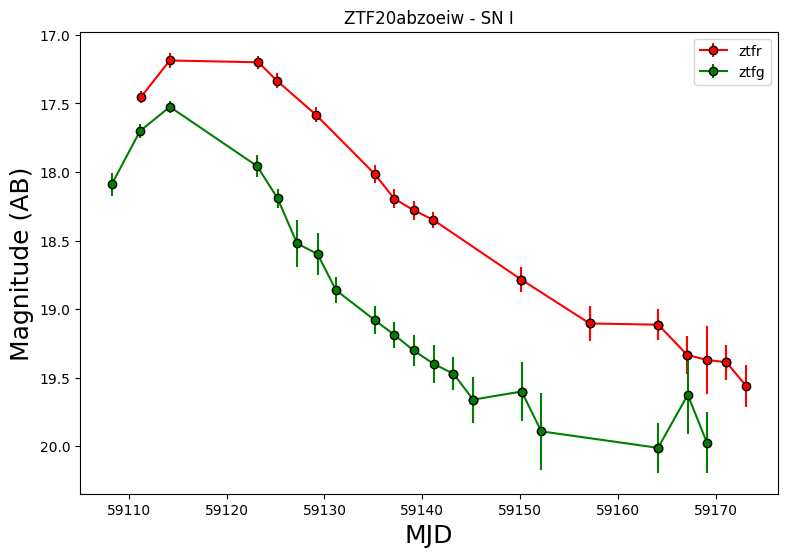

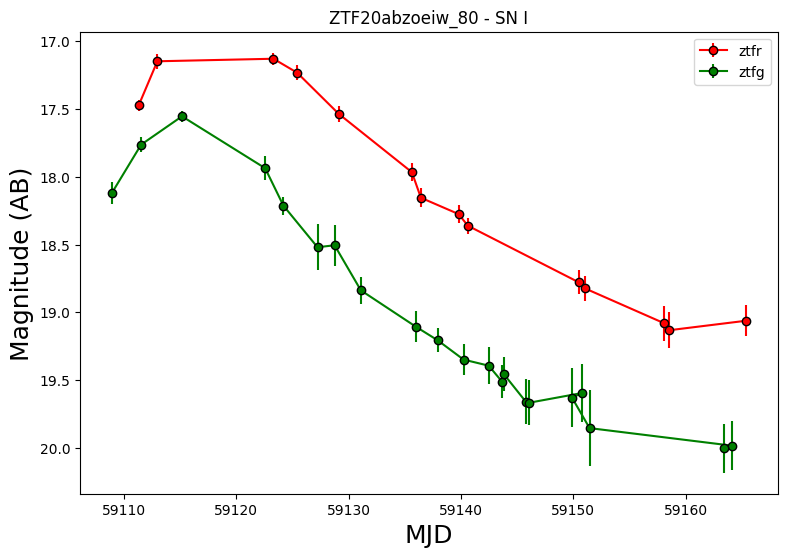

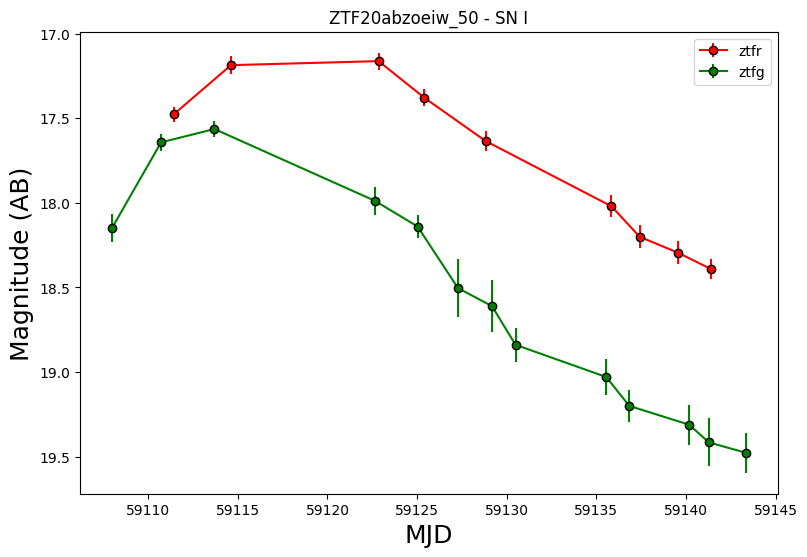

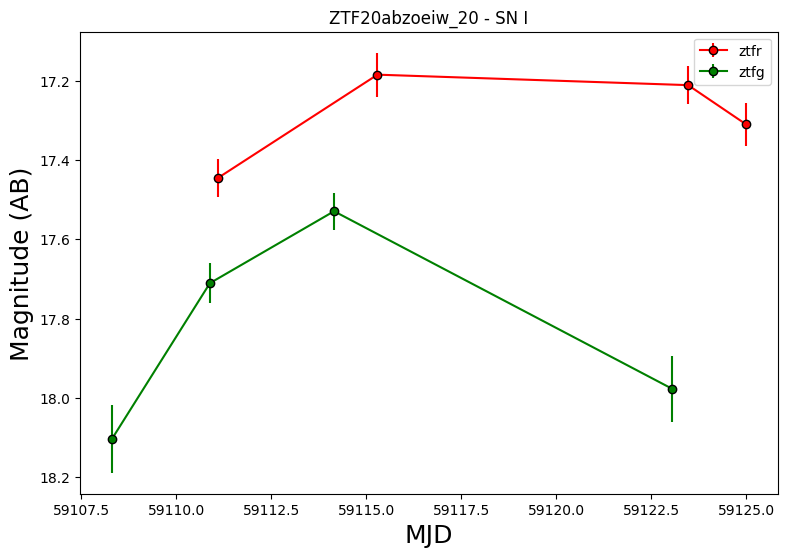

In [12]:
import re

obj_ids = photo_df['obj_id'].unique()
filtered_ids = [obj_id for obj_id in obj_ids if not re.search(r'_\d+$', obj_id)]

id_base = 'ZTF20abzoeiw'
#id_base = random.choice(filtered_ids)
relevant_ids = [obj_id for obj_id in photo_df['obj_id'].unique() if obj_id.startswith(id_base)]
for i, obj_id in enumerate(relevant_ids):
    one_df = photo_df[photo_df['obj_id'] == obj_id]
    plot_photometry(one_df)

In [53]:
def Mag2Flux(df):
    df_copy = df.dropna().copy()
    df_copy['flux'] = 10 ** (-0.4 * (df_copy['mag'] - 23.9))
    df_copy['flux_error'] = (df_copy['magerr'] / (2.5 / np.log(10))) * df_copy['flux']

    df_copy = df_copy[['obj_id', 'mjd', 'flux', 'flux_error', 'filter', 'type']]
    return df_copy

def Normalize(df):
    df_copy = df.dropna().copy()

    df_copy['mjd'] = df_copy.groupby('obj_id')['mjd'].transform(lambda x: x - np.min(x))

    df_copy.reset_index(drop=True, inplace=True)
    return df_copy

In [ ]:
photo_df = Mag2Flux(photo_df)
photo_df = Normalize(photo_df)
photo_df

In [ ]:
def count_obj_by_type(df):
    obj_id_count_per_type = df.groupby('type')['obj_id'].nunique()
    print(obj_id_count_per_type)

In [ ]:
count_obj_by_type(photo_df)

In [ ]:
filtered_df = photo_df.groupby('obj_id').filter(lambda x: x.groupby('filter')['mjd'].count().ge(3).sum() >= 2)

count_obj_by_type(filtered_df)

In [ ]:
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.to_csv('filtered_SNI_SNII_Other_photometry.csv', index=False)

In [13]:
filtered_df = pd.read_csv('../filtered_SNI_SNII_Other_photometry.csv')

In [14]:
filtered_df

,obj_id,mjd,flux,flux_error,filter,type
0,ZTF17aaajowi,0.000000,76.137803,12.288304,ztfr,Other
1,ZTF17aaajowi,11.105532,95.428923,11.953135,ztfr,Other
2,ZTF17aaajowi,18.026933,110.723539,5.879360,ztfg,Other
3,ZTF17aaajowi,26.975903,54.353767,4.054154,ztfg,Other
4,ZTF17aaajowi,26.975903,54.355103,4.054244,ztfg,Other
...,...,...,...,...,...,...
3052106,ZTF24aahdisu_80,13.660159,108.234525,11.299629,ztfg,Other
3052107,ZTF24aahdisu_80,13.538701,97.866738,10.396711,ztfg,Other
3052108,ZTF24aahdisu_80,13.986383,96.661018,4.508606,ztfg,Other
3052109,ZTF24aahdisu_80,14.327331,105.619387,4.336876,ztfr,Other


In [ ]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, test_idx = next(gss.split(filtered_df, groups=filtered_df['obj_id']))

train_data = filtered_df.iloc[train_idx]
test_data = filtered_df.iloc[test_idx]

In [ ]:
count_obj_by_type(train_data)
count_obj_by_type(test_data)

## Gaussian Process Application

![](./bandpass-list-18.png)

In [54]:

pb_wavelengths = {
    'ztfg': 4800.,
    'ztfr': 6400.,
    'ztfi': 7900.,
}

filters = ['ztfg', 'ztfr', 'ztfi']

gp_wavelengths = np.vectorize(pb_wavelengths.get)(filters)

inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items()}

# These functions are taken from the 'Paying Attention to Astronomical Transients' paper

def fit_2d_gp(obj_data, kernel=None, return_kernel=False, global_fit=False, **kwargs):
    if kernel is None:
        guess_length_scale = 20.0
        signal_to_noises = np.abs(obj_data.flux) / np.sqrt(
            obj_data.flux_error ** 2 + (1e-2 * np.max(obj_data.flux)) ** 2
        )
        scale = np.abs(obj_data.flux[signal_to_noises.idxmax()])
        kernel = (0.5 * scale) ** 2 * george.kernels.Matern32Kernel([
            guess_length_scale ** 2, 6000 ** 2], ndim=2)
        kernel.freeze_parameter("k2:metric:log_M_1_1")


    obj_times = obj_data.mjd.astype(float)
    obj_flux = obj_data.flux.astype(float)
    obj_flux_error = obj_data.flux_error.astype(float)
    obj_wavelengths = obj_data['filter'].map(pb_wavelengths)

    def neg_log_like(p):  # Objective function: negative log-likelihood
        gp.set_parameter_vector(p)
        loglike = gp.log_likelihood(obj_flux, quiet=True)
        return -loglike if np.isfinite(loglike) else 1e25

    def grad_neg_log_like(p):  # Gradient of the objective function.
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(obj_flux, quiet=True)

    gp = george.GP(kernel)
    default_gp_param = gp.get_parameter_vector()
    x_data = np.vstack([obj_times, obj_wavelengths]).T
    gp.compute(x_data, obj_flux_error)

    bounds = [(0, np.log(1000 ** 2))]
    bounds = [(default_gp_param[0] - 10, default_gp_param[0] + 10)] + bounds
    results = op.minimize(neg_log_like, gp.get_parameter_vector(),
                          jac=grad_neg_log_like, method="L-BFGS-B",
                          bounds=bounds, tol=1e-6)

    if results.success:
        gp.set_parameter_vector(results.x)
    else:
        # Fit failed. Print out a warning, and use the initial guesses for fit
        # parameters.
        obj = obj_data['obj_id'][0]
        print("GP fit failed for {}! Using guessed GP parameters.".format(obj))
        gp.set_parameter_vector(default_gp_param)

    gp_predict = partial(gp.predict, obj_flux)

    if return_kernel:
        return kernel, gp_predict
    else:
        return gp_predict


def predict_2d_gp(gp_predict, gp_times, gp_wavelengths):
    """Outputs the predictions of a Gaussian Process.

    Parameters
    ----------
    gp_predict : functools.partial of george.gp.GP
        The GP instance that was used to fit the object.
    gp_times : numpy.ndarray
        Times to evaluate the Gaussian Process at.
    gp_wavelengths : numpy.ndarray
        Wavelengths to evaluate the Gaussian Process at.

    Returns
    -------
    obj_gps : pandas.core.frame.DataFrame, optional
        Time, flux and flux error of the fitted Gaussian Process.
    """
    unique_wavelengths = np.unique(gp_wavelengths)
    number_gp = len(gp_times)
    obj_gps = []
    for wavelength in unique_wavelengths:
        gp_wavelengths = np.ones(number_gp) * wavelength
        pred_x_data = np.vstack([gp_times, gp_wavelengths]).T
        pb_pred, pb_pred_var = gp_predict(pred_x_data, return_var=True)
        # stack the GP results in a array momentarily
        obj_gp_pb_array = np.column_stack((gp_times, pb_pred, np.sqrt(pb_pred_var)))
        obj_gp_pb = Table(
            [
                obj_gp_pb_array[:, 0],
                obj_gp_pb_array[:, 1],
                obj_gp_pb_array[:, 2],
                [wavelength] * number_gp,
            ],
            names=["mjd", "flux", "flux_error", "filter"],
        )
        if len(obj_gps) == 0:  # initialize the table for 1st passband
            obj_gps = obj_gp_pb
        else:  # add more entries to the table
            obj_gps = vstack((obj_gps, obj_gp_pb))
            
    obj_gps = obj_gps.to_pandas()
    return obj_gps

def process_gaussian(df, kernel=None, number_gp=100, save=False, name=''):
    
    res_df = pd.DataFrame()

    for obj_id in tqdm.tqdm(df['obj_id'].unique()):
        obj_df = df[df['obj_id'] == obj_id]
        type_obj = obj_df['type'].values[0]
        obj_df.reset_index(drop=True, inplace=True)

        available_filters = obj_df['filter'].unique()
        gp_wavelengths = np.vectorize(pb_wavelengths.get)(available_filters)
        inverse_gp_wavelengths = {v: k for k, v in pb_wavelengths.items() if k in available_filters}
        gp_predict = fit_2d_gp(obj_df, kernel=kernel)
        gp_times = np.linspace(min(obj_df['mjd']), max(obj_df['mjd']), number_gp)

        obj_gps = predict_2d_gp(gp_predict, gp_times, gp_wavelengths)
        obj_gps['filter'] = obj_gps['filter'].map(inverse_gp_wavelengths)

        obj_gps = obj_gps.pivot_table(index=['mjd'], columns='filter', values=['flux', 'flux_error'])
        obj_gps = obj_gps.reset_index()
        obj_gps.columns = [col[0] if col[0] == 'mjd' else '_'.join(col).strip() for col in obj_gps.columns.values]
        obj_gps['type'] = type_obj
        obj_gps['obj_id'] = obj_id

        res_df = pd.concat([res_df, obj_gps])

    res_df.reset_index(drop=True, inplace=True)

    if save:
        types_str = '_'.join(df['type'].unique()) if hasattr(df['type'].unique(), '__iter__') else str(df['type'].unique())
        filename = f'{name}_gp_{types_str}.csv'
        filename = filename.replace(' ', '_')
        res_df.to_csv(filename, index=False)
        print(f'File {filename} saved successfully')
    return res_df

In [ ]:
kernel, _ = fit_2d_gp(mini_data, kernel=None, return_kernel=True)

In [ ]:
test_results = process_gaussian(test_data, kernel=kernel, name='test', save=True)

In [ ]:
train_results = process_gaussian(train_data, kernel=kernel, name='train', save=True)

In [15]:
all_gp = pd.read_csv('test_gp_SN_I_SN_II_Other.csv')

In [ ]:
def good_number_of_obj_id(df_gp, df_photo):
    df_sni_gp = df_gp[df_gp['type'] == 'SN I']
    df_snii_gp = df_gp[df_gp['type'] == 'SN II']

    df_sni_photo = df_photo[df_photo['type'] == 'SN I']
    df_snii_photo = df_photo[df_photo['type'] == 'SN II']

    assert df_sni_gp['obj_id'].nunique() == df_sni_photo['obj_id'].nunique(), f"Number of unique objects for SN I is different between Gaussian Process and Photometry: {df_sni_gp['obj_id'].nunique()} vs {df_sni_photo['obj_id'].nunique()}"
    assert df_snii_gp['obj_id'].nunique() == df_snii_photo['obj_id'].nunique(), f"Number of unique objects for SN II is different between Gaussian Process and Photometry: {df_snii_gp['obj_id'].nunique()} vs {df_snii_photo['obj_id'].nunique()}"

    print(f"Number of unique objects for SN I: {df_sni_gp['obj_id'].nunique()}")
    print(f"Number of unique objects for SN II: {df_snii_gp['obj_id'].nunique()}")
    print("Number of unique objects is the same between Gaussian Process and Photometry")

In [ ]:
good_number_of_obj_id(all_gp, photo_df)

## Data Standardization

In [5]:
from sklearn.preprocessing import RobustScaler

def robust_scale(dataframe, scale_columns):
    scaler = RobustScaler()
    scaler = scaler.fit(dataframe[scale_columns])
    dataframe.loc[:, scale_columns] = scaler.transform(
        dataframe[scale_columns].to_numpy()
    )
    return dataframe

In [7]:
scale_columns = ['flux_ztfg', 'flux_ztfr', 'flux_ztfi', 'flux_error_ztfg', 'flux_error_ztfr', 'flux_error_ztfi']
all_gp = robust_scale(all_gp, scale_columns)
all_gp

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,mjd,flux_ztfg,flux_ztfr,flux_error_ztfg,flux_error_ztfr,type,obj_id,flux_ztfi,flux_error_ztfi
0,0.000000,-0.032993,0.052153,-0.085046,0.464546,SN I,ZTF17aacldgo,NaN,NaN
1,0.130164,-0.019983,0.054279,-0.116190,0.396964,SN I,ZTF17aacldgo,NaN,NaN
2,0.260327,-0.006957,0.056352,-0.145047,0.330706,SN I,ZTF17aacldgo,NaN,NaN
3,0.390491,0.006051,0.058372,-0.171715,0.265839,SN I,ZTF17aacldgo,NaN,NaN
4,0.520654,0.019005,0.060339,-0.196291,0.202442,SN I,ZTF17aacldgo,NaN,NaN
...,...,...,...,...,...,...,...,...,...
828695,17.582981,1.191762,1.047959,3.468364,0.461083,Other,ZTF24aagwwkr_50,NaN,NaN
828696,17.768065,1.183666,1.041401,3.498453,0.405643,Other,ZTF24aagwwkr_50,NaN,NaN
828697,17.953149,1.175195,1.034373,3.531234,0.386233,Other,ZTF24aagwwkr_50,NaN,NaN
828698,18.138233,1.166352,1.026856,3.566908,0.406272,Other,ZTF24aagwwkr_50,NaN,NaN


## Visualizations of Gaussian Processes

In [8]:
def plot_gp(obj_model, number_col=4, show_title=True, show_legend=True):
    color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'yellow'}
    f, ax = plt.subplots(figsize=(10, 6))

    # Plotting model data if available
    if obj_model is not None:
        # Iterate over the filters present in the obj_model DataFrame
        for column in obj_model.columns:
            if 'flux' in column and column != 'mjd':
                filter_name = column.split('_')[1]
                if filter_name in color_dict:
                    if not all(obj_model[column] == -1):
                        ax.plot(obj_model['mjd'], obj_model[column], label=f'Model {filter_name}', color=color_dict[filter_name])
    
                        # Plot error band if error data is available
                        error_column = f'flux_error_{filter_name}'
                        if error_column in obj_model.columns:
                            model_flux_error = obj_model[error_column]
                            ax.fill_between(obj_model['mjd'], obj_model[column]-model_flux_error, obj_model[column]+model_flux_error, color=color_dict[filter_name], alpha=0.20)

    ax.set_xlabel('Time (mjd)')
    ax.set_ylabel('Flux')
    if show_title:
        obj_id = obj_model['obj_id'].iloc[0]
        ax.set_title(f'Light Curve for Object ID: {obj_id} | Type: {obj_model["type"].iloc[0]}')
    if show_legend:
        ax.legend(ncol=number_col)
    
    plt.show()

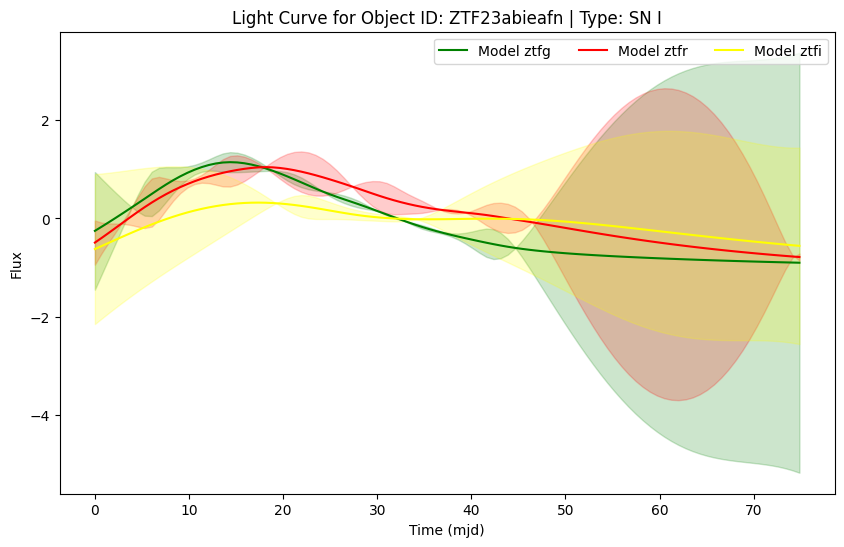

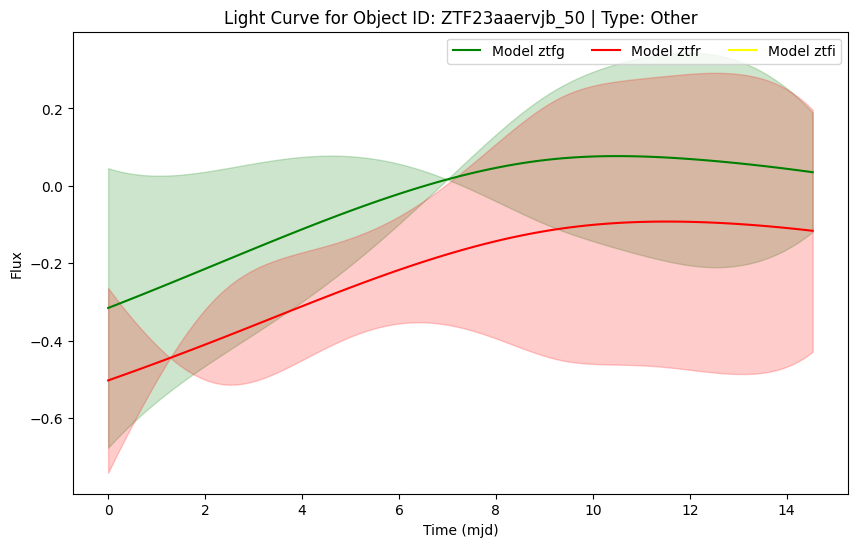

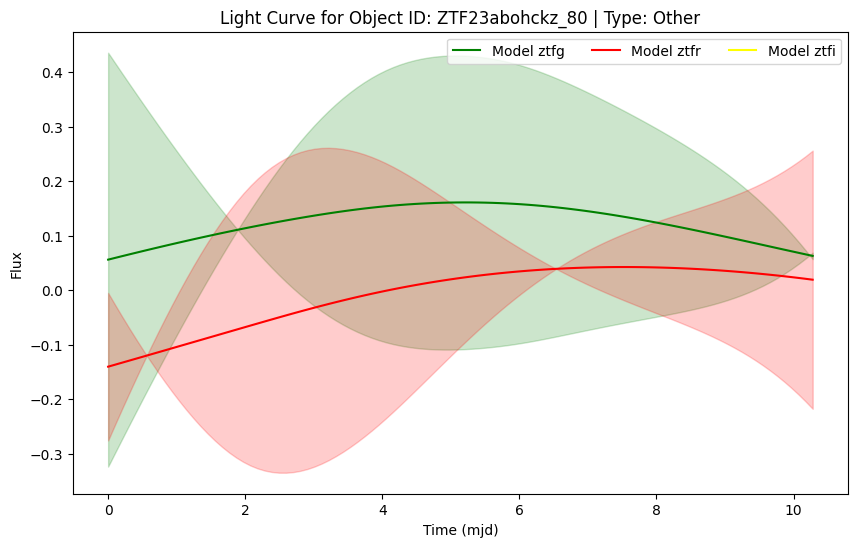

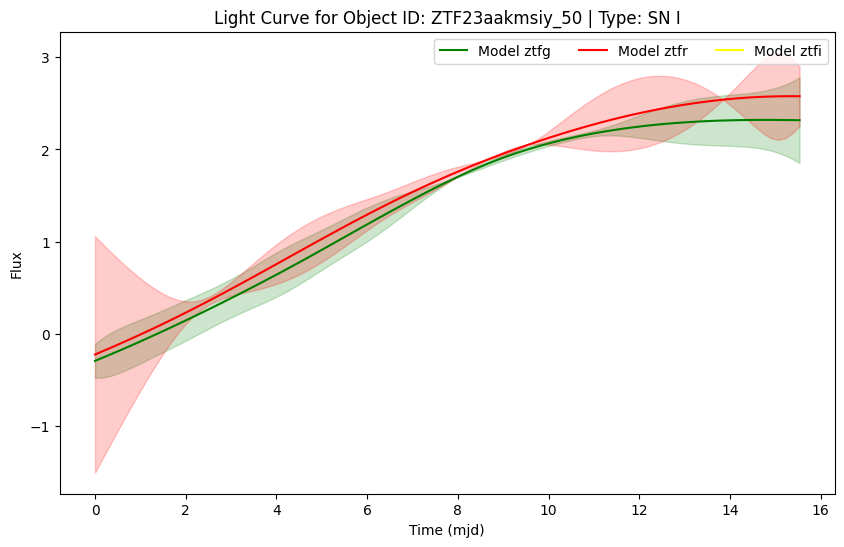

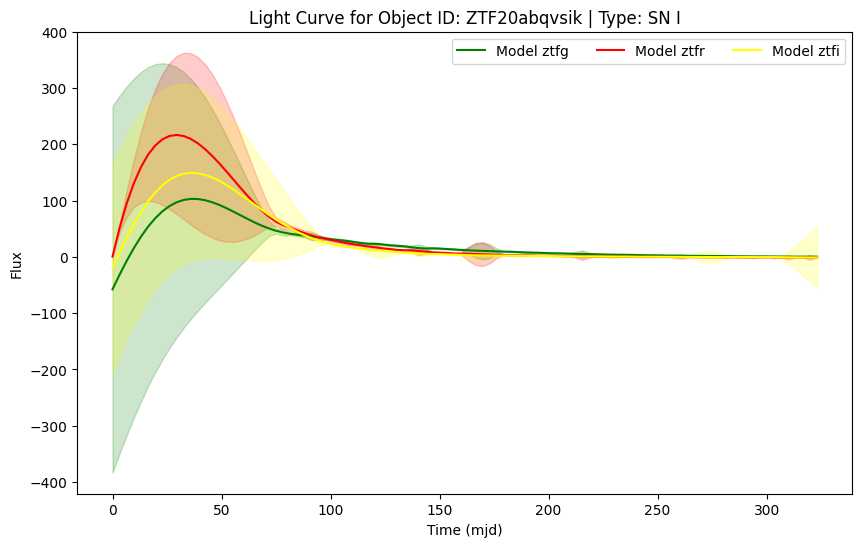

In [9]:
obj_ids = all_gp['obj_id'].unique()
for i in range(5):
    id_1 = random.choice(obj_ids)
    one_df = all_gp[all_gp['obj_id'] == id_1]
    plot_gp(one_df)

In [10]:
all_gp.dropna(inplace=True)
all_gp.reset_index(inplace=True)
all_gp

,index,mjd,flux_ztfg,flux_ztfr,flux_error_ztfg,flux_error_ztfr,type,obj_id,flux_ztfi,flux_error_ztfi
0,100,0.000000,1.120444,1.382482,3.290392,-0.615509,SN II,ZTF18aabssth,1.212317,1.401616
1,101,11.202161,0.940687,1.211226,3.249827,-0.415085,SN II,ZTF18aabssth,1.039482,1.380545
2,102,22.404322,0.708327,0.758487,3.231563,-0.269183,SN II,ZTF18aabssth,0.810563,1.372658
3,103,33.606483,0.456702,0.281668,3.219701,-0.468083,SN II,ZTF18aabssth,0.562925,1.368461
4,104,44.808644,0.222245,0.007090,3.209684,-0.501236,SN II,ZTF18aabssth,0.337353,1.365952
...,...,...,...,...,...,...,...,...,...,...
324195,828295,21.359379,11.330494,9.766470,-0.000880,5.286748,SN I,ZTF24aagozfg_80,5.004093,6.607336
324196,828296,21.584214,11.402454,9.694921,-0.120555,4.326203,SN I,ZTF24aagozfg_80,5.078861,7.067474
324197,828297,21.809050,11.403949,9.623781,0.298438,3.037448,SN I,ZTF24aagozfg_80,5.148791,7.511072
324198,828298,22.033885,11.343171,9.549947,1.004552,1.487124,SN I,ZTF24aagozfg_80,5.212689,7.952360


## Data Preparation for Modeling

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

grouped = all_gp.groupby('obj_id')
sequences = [group[['mjd', 'flux_ztfg', 'flux_ztfi', 'flux_ztfr']].values for _, group in grouped]

types = all_gp[['obj_id', 'type']].drop_duplicates().sort_values('obj_id')['type']
encoder = OneHotEncoder(sparse_output=False)
encoded_labels = encoder.fit_transform(types.values.reshape(-1, 1))
label_names = encoder.categories_[0]

padded_sequences = pad_sequences(sequences, padding='post', dtype='float32')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

2024-04-17 18:45:14.285839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 18:45:14.285961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 18:45:14.415912: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


X_train shape: (2593, 100, 4)
y_train shape: (2593, 3)
X_test shape: (649, 100, 4)
y_test shape: (649, 3)


## Data Augmentation

In [12]:
def filter_by_class(X, y, labels, target_class):
    class_index = np.where(np.array(labels) == target_class)[0][0]
    indices = np.where(y[:, class_index] == 1)[0]
    return X[indices], y[indices]

def time_shift(X, shift=1):
    if shift > 0:
        X_shifted = np.pad(X, ((0, 0), (shift, 0), (0, 0)), mode='constant', constant_values=0)[:, :-shift, :]
    else:
        X_shifted = np.pad(X, ((0, 0), (0, -shift), (0, 0)), mode='constant', constant_values=0)[:, -shift:, :]
    return X_shifted

def balance_classes(X, y, labels, min_samples_per_class=5000):
    num_classes = y.shape[1]
    current_counts = np.sum(y, axis=0)
    X_augmented = [X]
    y_augmented = [y]
    ranges = [-15, 15]

    for class_index in range(num_classes):
        needed = min_samples_per_class - current_counts[class_index]
        print(needed)
        if needed > 0:
            X_class, y_class = filter_by_class(X, y, labels, target_class=labels[class_index])
            if len(X_class) > 0:
                factor = int(needed // len(X_class)) + 1

                print(factor)

                for _ in range(factor):
                    for shift in ranges:
                        X_shifted = time_shift(X_class, shift=shift)
                        X_augmented.append(X_shifted)
                        y_augmented.append(y_class)

                additional_needed = needed - (factor * len(X_class) * 5)
                if additional_needed > 0:
                    repeat_times = int(additional_needed // len(X_class)) + 1
                    for _ in range(repeat_times):
                        X_augmented.append(X_class)
                        y_augmented.append(y_class)

    X_balanced = np.concatenate(X_augmented, axis=0)
    y_balanced = np.concatenate(y_augmented, axis=0)

    return X_balanced, y_balanced

4291.0
7
3566.0
3
4550.0
11


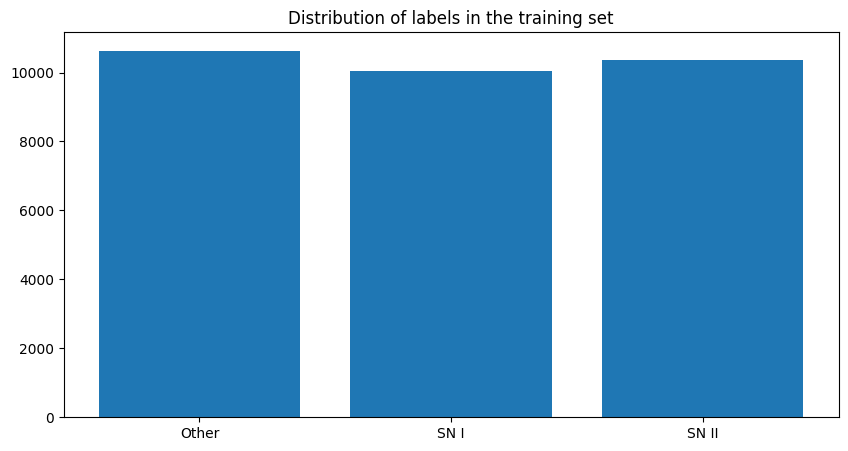

In [13]:
X_balanced, y_balanced = balance_classes(X_train, y_train, label_names)

plt.figure(figsize=(10, 5))
plt.bar(label_names, y_balanced.sum(axis=0))
plt.title('Distribution of labels in the training set')
plt.show()

In [14]:
X_train = X_balanced
y_train = y_balanced

In [15]:
from sklearn.utils.class_weight import compute_class_weight

y_train_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_integers), y=y_train_integers)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}

class_weight_dict

{0: 0.9723554301833568, 1: 1.0301852958756725, 2: 0.9991304347826087}

In [16]:
print("NaN in X_train:", np.isnan(X_train).any())
print("Inf in X_train:", np.isinf(X_train).any())

NaN in X_train: False
Inf in X_train: False


## Model Construction

In [17]:
from tensorflow.keras import layers

class ConvEmbedding(layers.Layer):
    def __init__(self, num_filters, kernel_size=1, activation='relu'):
        super(ConvEmbedding, self).__init__()
        self.conv1d = layers.Conv1D(filters=num_filters, kernel_size=kernel_size, activation=activation)

    def call(self, inputs):
        return self.conv1d(inputs)

In [18]:
import tensorflow as tf

class PositionalEncoding(layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # apply sin to even indices in the array; 2i
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd indices in the array; 2i+1
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:tf.shape(inputs)[1], :]

In [19]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, query, key, value, mask=None):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        if mask is not None:
            mask = tf.cast(mask, dtype=logits.dtype)
            logits += (1.0 - mask) * -1e9
        weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def call(self, inputs, mask=None):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.scaled_dot_product_attention(query, key, value, mask=mask)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

In [20]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"), 
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, mask=None, training=False):
        attn_output = self.att(inputs, mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [21]:
class MaskingLayer(layers.Layer):
    def __init__(self, mask_value=-999.0):
        super(MaskingLayer, self).__init__()
        self.mask_value = mask_value

    def call(self, inputs):
        mask = tf.math.not_equal(inputs, self.mask_value)
        mask = tf.reduce_any(mask, axis=-1)
        mask = mask[:, tf.newaxis, tf.newaxis, :]
        return inputs, mask

In [22]:
import tensorflow as tf
from tensorflow.keras import layers

class T2Model(tf.keras.Model):
    def __init__(self, num_filters, num_classes, num_layers, d_model, num_heads, dff, input_shape, rate=0.1):
        super(T2Model, self).__init__()
        self.masking_layer = MaskingLayer(mask_value=-999.0)
        self.embedding = ConvEmbedding(num_filters=num_filters)
        self.pos_encoding = PositionalEncoding(100, d_model)
        self.encoder_layers = [TransformerBlock(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = layers.Dropout(rate)
        self.final_layer = layers.Dense(num_classes, activation='softmax')

    def call(self, x, training=False):
        x, mask = self.masking_layer(x)     
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for layer in self.encoder_layers:
            x = layer(x, training=training, mask=mask)
        x = layers.GlobalAveragePooling1D()(x)
        x = self.dropout(x, training=training)
        return self.final_layer(x)

    def build(self, input_shape):
        x = tf.keras.Input(shape=input_shape)
        return self.call(x)

## Model Compilation

In [23]:
sequence_length = X_train.shape[1]
feature_dim = X_train.shape[2]
num_classes = y_train.shape[1]

print("Sequence length:", sequence_length)
print("Feature dimension:", feature_dim)
print("Number of classes:", num_classes)

Sequence length: 100
Feature dimension: 4
Number of classes: 3


In [33]:
from tensorflow.keras.optimizers import Adam

num_filters = 64
num_layers = 2
d_model = 64
num_heads = 4
dff = 64
rate = 0.3

model = T2Model(num_filters=num_filters, num_classes=num_classes, num_layers=num_layers,
                d_model=d_model, num_heads=num_heads, dff=dff, rate=rate, input_shape=(sequence_length, feature_dim))

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

model.build(input_shape=(sequence_length, feature_dim))
model.summary()

Model: "t2_model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_layer_4 (MaskingLayer)  │ [(None, 100, 4),       │             0 │
│                                 │ (None, 1, 1, 100)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_embedding_4                │ (None, 100, 64)        │           320 │
│ (ConvEmbedding)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_4           │ (None, 100, 64)        │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_12            │ (None, 100, 64)        │        25,216 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_13            │ (None, 100, 64)        │        25,216 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,947 (199.01 KB)

 Trainable params: 50,947 (199.01 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
filepath = "best_model.keras"

callbacks_list = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15),
    ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, mode='min', verbose=1),
]

In [35]:
print("GPUs disponibles : ", tf.config.list_physical_devices('GPU'))

GPUs disponibles :  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Model Training

In [36]:
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=callbacks_list,
    class_weight=class_weight_dict)

Epoch 1/150
776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5701 - loss: 0.9224
Epoch 1: val_loss improved from inf to 1.27005, saving model to best_model.keras
776/776 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.5701 - loss: 0.9222 - val_accuracy: 0.3537 - val_loss: 1.2701 - learning_rate: 0.0010
Epoch 2/150
771/776 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6909 - loss: 0.7147
Epoch 2: val_loss improved from 1.27005 to 0.95800, saving model to best_model.keras
776/776 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6909 - loss: 0.7146 - val_accuracy: 0.5755 - val_loss: 0.9580 - learning_rate: 0.0010
Epoch 3/150
773/776 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6997 - loss: 0.6809
Epoch 3: val_loss did not improve from 0.95800
776/776 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6997 - loss: 0.6809 - val_accuracy: 0.4907 - val_loss: 1.0680 - learning_rate: 0.0010
Epoch 4/150
775/776 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7092 - loss: 0.6597
Epoch 4: val_

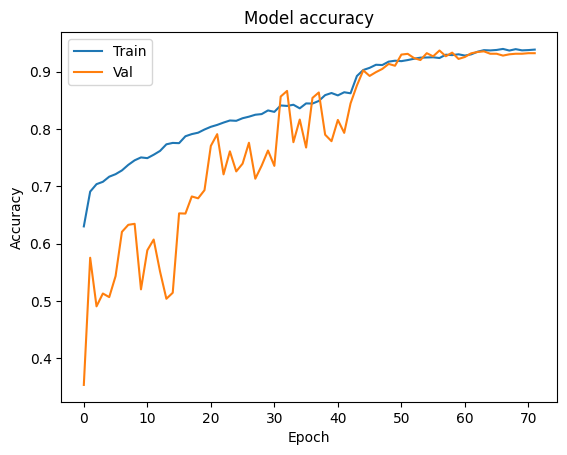

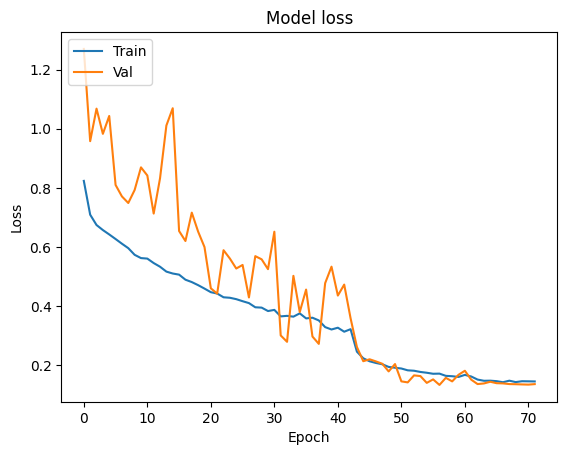

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Loading the Best Model

In [38]:
model.load_weights('/kaggle/working/best_model.keras')

## Testing on Test Data

In [39]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6929 - loss: 1.7625
Test Loss: 1.945, Test Accuracy: 0.676


## Evaluation and Visualization

### Classification Report

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_names))

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step
              precision    recall  f1-score   support

       Other       0.53      0.51      0.52       174
        SN I       0.79      0.77      0.78       359
       SN II       0.55      0.62      0.59       116

    accuracy                           0.68       649
   macro avg       0.63      0.64      0.63       649
weighted avg       0.68      0.68      0.68       649



### ROC Curve

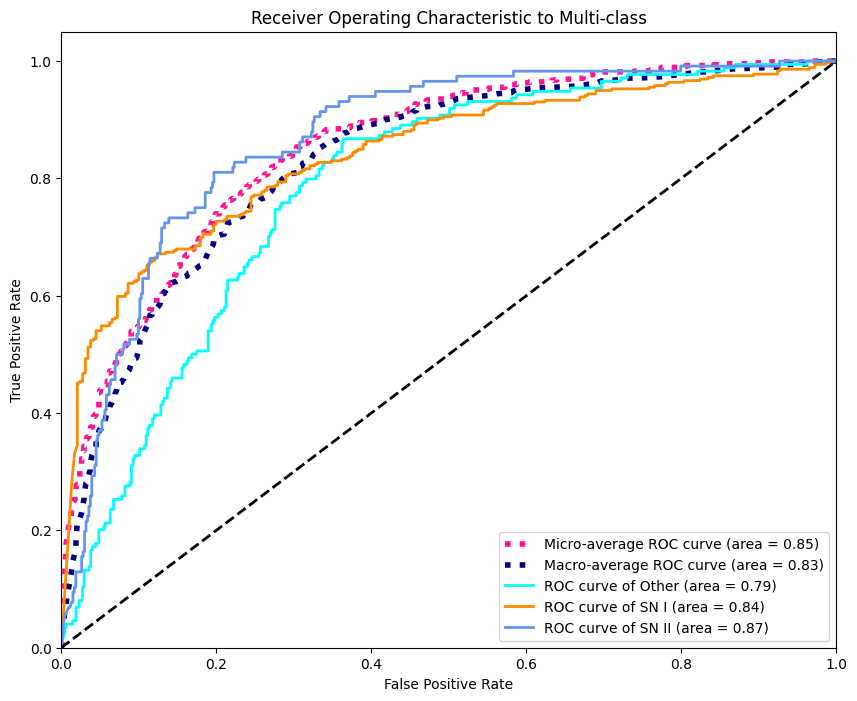

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from numpy import interp
from itertools import cycle
import numpy as np

fpr, tpr, roc_auc = dict(), dict(), dict()
n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='Micro-average ROC curve (area = {:.2f})'.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (area = {:.2f})'.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of {} (area = {:.2f})'.format(label_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-class')
plt.legend(loc="lower right")
plt.show()

### Confusion Matrix

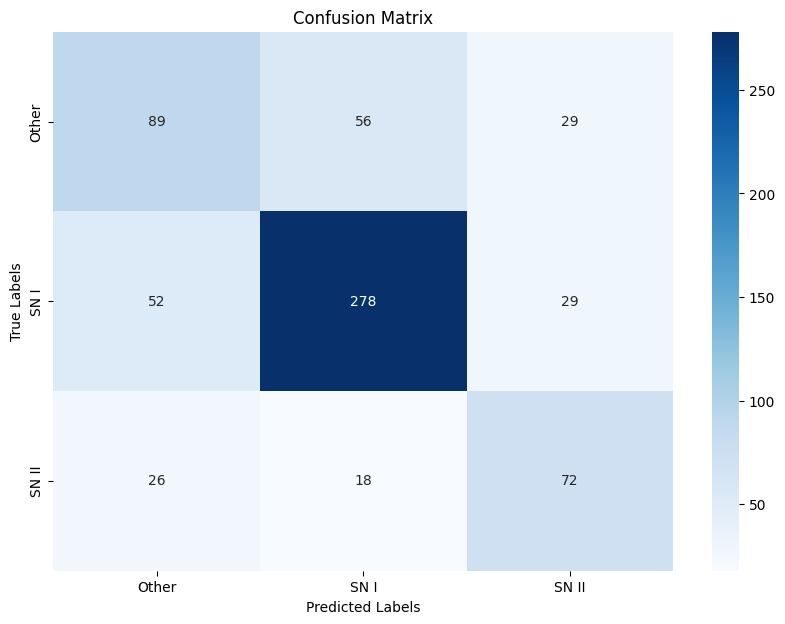

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_classes)

cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Accuracy per Class

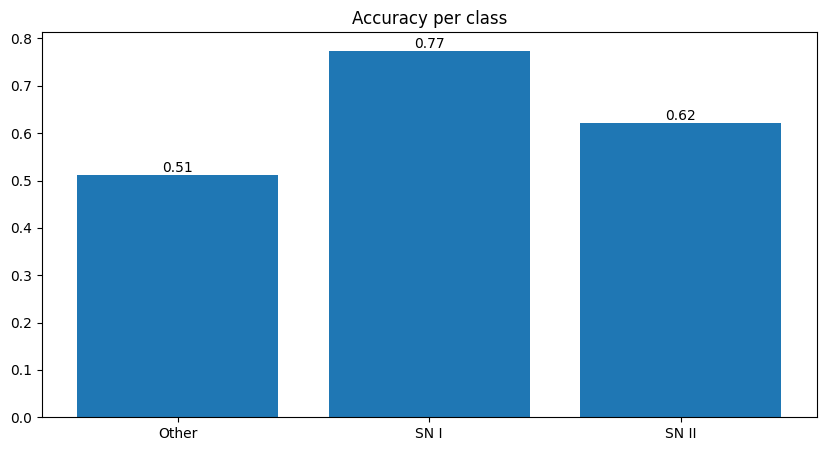

In [43]:
correct = np.zeros(n_classes)
total = np.zeros(n_classes)
for i in range(len(y_true)):
    total[y_true[i]] += 1
    if y_true[i] == y_pred_classes[i]:
        correct[y_true[i]] += 1

percentages = correct / total

plt.figure(figsize=(10, 5))
plt.bar(label_names, percentages)
for i, percentage in enumerate(percentages):
    plt.text(i, percentage, f'{percentage:.2f}', ha='center', va='bottom')

plt.title('Accuracy per class')
plt.show()

### Early Classification Trade-Off

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


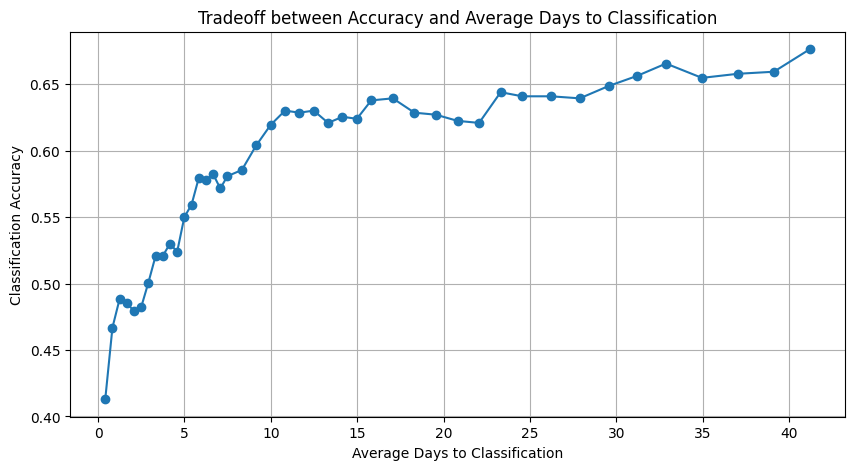

In [47]:
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d

def resample_series(X, num_points, new_length=100):
    """
    Resamples time series data to a fixed number of points using linear interpolation.
    
    Parameters:
        X (array): The input array containing time series data of shape (n_samples, n_timesteps, n_features).
        num_points (int): The number of time points to use from the original series for interpolation.
        new_length (int): The new number of time points desired for each series.
    
    Returns:
        numpy.array: The resampled time series data.
    """
    X_resampled = np.zeros((X.shape[0], new_length, X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            interp_func = interp1d(np.arange(num_points), X[i, :num_points, j], kind='linear', fill_value='extrapolate')
            X_resampled[i, :, j] = interp_func(np.linspace(0, num_points - 1, new_length))
    return X_resampled

def early_classification_tradeoff(model, X_test, y_test, reduction_step=0.05, mcat=0.2):
    """
    Evaluates the trade-off between classification accuracy and average days for early prediction.

    Parameters:
        model (Model): The trained classification model.
        X_test (array): Test dataset.
        y_test (array): True labels for the test dataset.
        reduction_step (float): Fractional reduction of the series length in each iteration.
        mcat (float): Minimum classification accuracy threshold to continue reduction.

    Returns:
        tuple: Lists containing actual average days used and their corresponding accuracies.
    """
    accuracies = []
    average_days = []
    current_index = X_test.shape[1]  # Start with the maximum length of series

    while current_index > 0 and (len(accuracies) == 0 or accuracies[-1] >= mcat):
        # Calculate average days from the first time point to the current index
        avg_days = np.mean(X_test[:, :current_index, 0], axis=1) - X_test[:, 0, 0]
        mean_avg_days = np.mean(avg_days)

        truncated_X_test = X_test[:, :current_index, :]
        resampled_X_test = resample_series(truncated_X_test, current_index)
        y_pred_proba = model.predict(resampled_X_test)
        y_pred_classes = np.argmax(y_pred_proba, axis=1)
        accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes)

        accuracies.append(accuracy)
        average_days.append(mean_avg_days)

        current_index = int(current_index * (1 - reduction_step))
        if current_index <= 1:
            break

    plt.figure(figsize=(10, 5))
    plt.plot(average_days, accuracies, marker='o', linestyle='-')
    plt.title('Tradeoff between Accuracy and Average Days to Classification')
    plt.xlabel('Average Days to Classification')
    plt.ylabel('Classification Accuracy')
    plt.grid(True)
    plt.show()

    return average_days, accuracies

actual_lengths, accuracies = early_classification_tradeoff(model, X_test, y_test)

## Testing on New Data

In [48]:
new_df = pd.read_csv('/kaggle/input/photometry-new/photometry_new_data.csv')
new_df

,obj_id,mjd,mag,magerr,snr,limiting_mag,filter,type
0,ZTF18accwosm,58426.538785,19.935289,0.205227,5.290424,20.134668,ztfr,No
1,ZTF18accwosm,60380.269491,20.443600,0.341427,3.179995,20.018499,ztfg,No
2,ZTF18accwosm,60380.274387,NaN,NaN,NaN,19.168900,ztfg,No
3,ZTF18accwosm,60380.275324,NaN,NaN,NaN,18.885201,ztfg,No
4,ZTF18accwosm,60388.293808,NaN,NaN,NaN,19.535601,ztfg,No
...,...,...,...,...,...,...,...,...
58763,ZTF24aajmlok,60412.251852,NaN,NaN,NaN,19.812300,ztfi,No
58764,ZTF24aajmlok,60413.142049,21.101999,0.175057,6.202187,21.391001,ztfg,No
58765,ZTF24aajmlok,60413.157662,21.314400,0.209869,5.173400,21.385099,ztfr,No
58766,ZTF24aajmlok,60413.173310,21.091101,0.150769,7.201323,21.560900,ztfg,No


In [49]:
new_df['obj_id'].nunique()

429

In [50]:
new_df = new_df[new_df['filter'].isin(['ztfg', 'ztfr', 'ztfi'])]
new_df.dropna(inplace=True)
new_df.reset_index(drop=True, inplace=True)
new_df

/tmp/ipykernel_34/2314957833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.dropna(inplace=True)


,obj_id,mjd,mag,magerr,snr,limiting_mag,filter,type
0,ZTF18accwosm,58426.538785,19.935289,0.205227,5.290424,20.134668,ztfr,No
1,ZTF18accwosm,60380.269491,20.443600,0.341427,3.179995,20.018499,ztfg,No
2,ZTF18accwosm,60404.270347,19.806499,0.335403,3.237109,19.598000,ztfi,No
3,ZTF18accwosm,60409.237951,20.362400,0.164754,6.590044,20.830700,ztfg,No
4,ZTF18accwosm,60410.153669,20.419201,0.150551,7.211750,20.960899,ztfr,No
...,...,...,...,...,...,...,...,...
24379,ZTF22abycpux,60413.317164,21.340307,0.174537,6.220671,21.552206,ztfg,No
24380,ZTF24aajmlok,60413.142049,21.101999,0.175057,6.202187,21.391001,ztfg,No
24381,ZTF24aajmlok,60413.157662,21.314400,0.209869,5.173400,21.385099,ztfr,No
24382,ZTF24aajmlok,60413.173310,21.091101,0.150769,7.201323,21.560900,ztfg,No


In [51]:
new_df['obj_id'].nunique()

429

In [55]:
new_df = Mag2Flux(new_df)
new_df = Normalize(new_df)

In [56]:
new_gp = process_gaussian(new_df, save=True)
new_gp

 10%|▉         | 41/429 [00:04<00:45,  8.47it/s]/opt/conda/lib/python3.10/site-packages/george/gp.py:321: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._yerr2 = float(yerr) ** 2 * np.ones(len(x))
 14%|█▍        | 62/429 [00:06<00:20, 18.07it/s]/opt/conda/lib/python3.10/site-packages/george/gp.py:321: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._yerr2 = float(yerr) ** 2 * np.ones(len(x))
 16%|█▌        | 69/429 [00:06<00:17, 20.67it/s]/opt/conda/lib/python3.10/site-packages/george/gp.py:321: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._yerr2 = float(yerr) ** 2 * np.ones(len(x))
 17%|█▋        | 72/429 [00:06<00:16, 21.65it/s]/opt/conda/lib/python3.10/site-packages/george/gp.py

File _gp_No.csv saved successfully


,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id
0,0.000000,33.211951,33.509630,36.055757,12.606813,12.161929,7.045940,No,ZTF18accwosm
1,20.068541,19.499555,19.598691,20.343953,23.663069,23.617587,23.265324,No,ZTF18accwosm
2,40.137082,7.193313,7.216606,7.388719,27.243092,27.239674,27.214063,No,ZTF18accwosm
3,60.205624,2.263856,2.269213,2.308561,27.713716,27.713473,27.711670,No,ZTF18accwosm
4,80.274165,0.657699,0.658924,0.667897,27.760646,27.760629,27.760511,No,ZTF18accwosm
...,...,...,...,...,...,...,...,...,...
40024,0.171494,12.704384,NaN,11.024326,1.105791,NaN,1.848858,No,ZTF24aajmlok
40025,0.173300,12.704384,NaN,11.024326,1.105791,NaN,1.848858,No,ZTF24aajmlok
40026,0.175105,12.704383,NaN,11.024326,1.105792,NaN,1.848859,No,ZTF24aajmlok
40027,0.176910,12.704383,NaN,11.024326,1.105793,NaN,1.848860,No,ZTF24aajmlok


In [57]:
scale_columns = ['flux_ztfg', 'flux_ztfr', 'flux_ztfi', 'flux_error_ztfg', 'flux_error_ztfr', 'flux_error_ztfi']
new_gp_gp = robust_scale(new_gp, scale_columns)
new_gp

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


,mjd,flux_ztfg,flux_ztfi,flux_ztfr,flux_error_ztfg,flux_error_ztfi,flux_error_ztfr,type,obj_id
0,0.000000,0.925344,0.188560,1.048481,1.537582,0.174769,0.770519,No,ZTF18accwosm
1,20.068541,0.081451,-0.295649,0.135017,3.439380,1.025489,3.904454,No,ZTF18accwosm
2,40.137082,-0.675905,-0.726641,-0.618183,4.055183,1.294472,4.667436,No,ZTF18accwosm
3,60.205624,-0.979276,-0.898848,-0.913537,4.136136,1.329658,4.763584,No,ZTF18accwosm
4,80.274165,-1.078122,-0.954899,-1.008923,4.144208,1.333160,4.773021,No,ZTF18accwosm
...,...,...,...,...,...,...,...,...,...
40024,0.171494,-0.336741,NaN,-0.406814,-0.440721,NaN,-0.233669,No,ZTF24aajmlok
40025,0.173300,-0.336741,NaN,-0.406814,-0.440721,NaN,-0.233669,No,ZTF24aajmlok
40026,0.175105,-0.336741,NaN,-0.406814,-0.440721,NaN,-0.233669,No,ZTF24aajmlok
40027,0.176910,-0.336741,NaN,-0.406814,-0.440721,NaN,-0.233668,No,ZTF24aajmlok


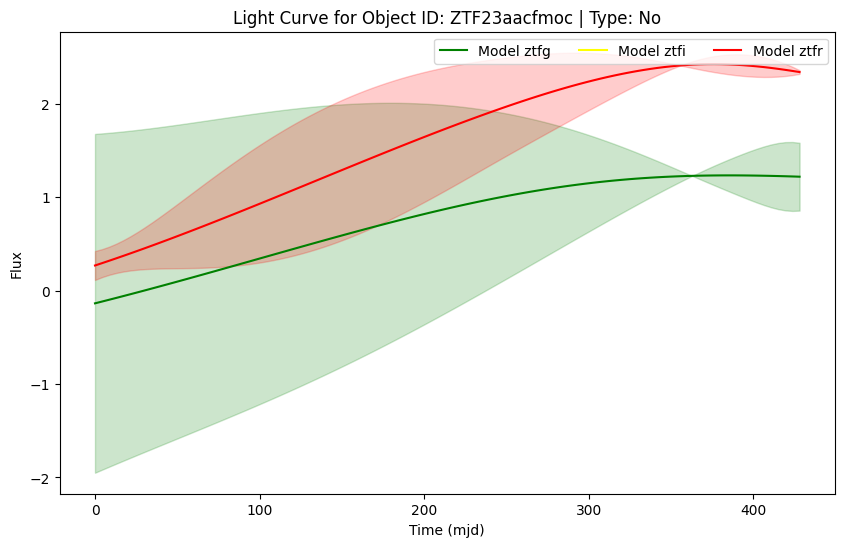

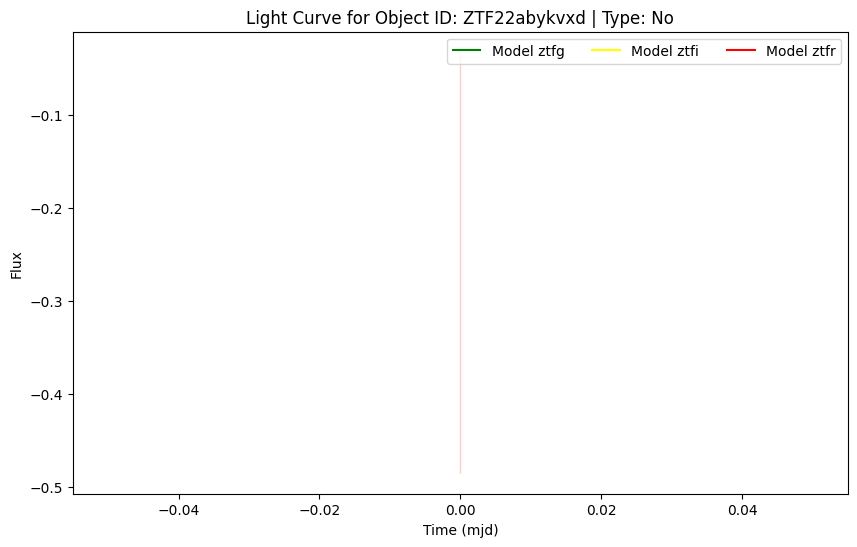

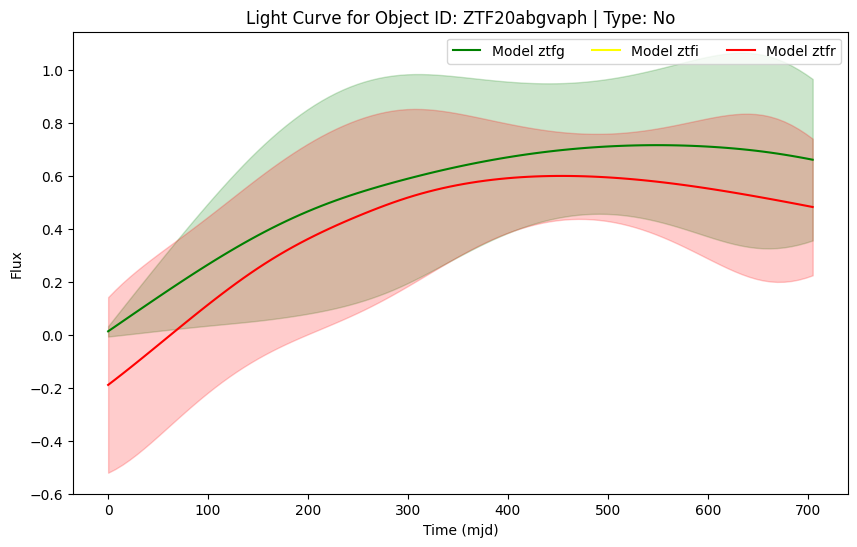

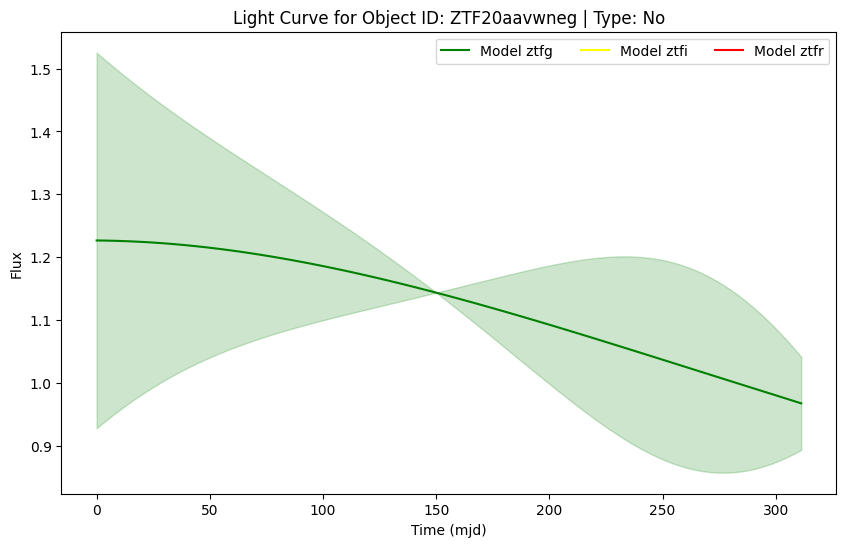

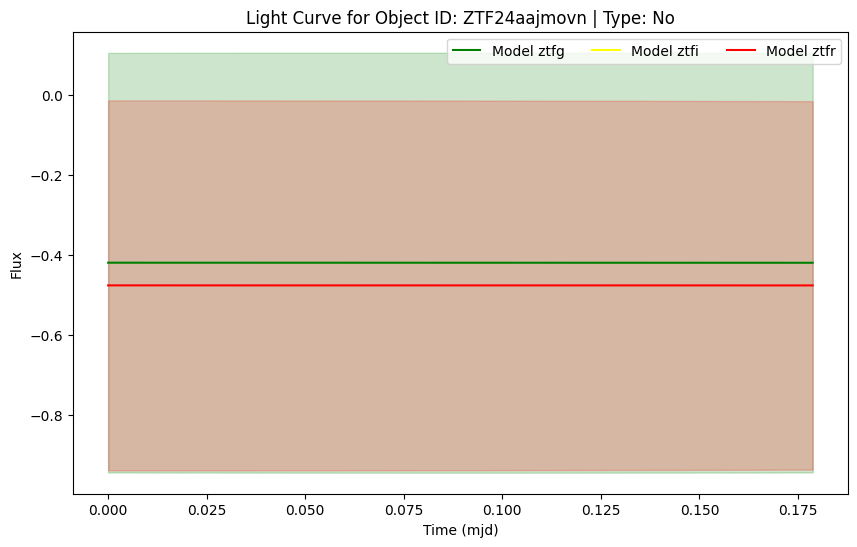

In [58]:
obj_ids = new_gp['obj_id'].unique()
for i in range(5):
    id_1 = random.choice(obj_ids)
    one_df = new_gp[new_gp['obj_id'] == id_1]
    plot_gp(one_df)

In [59]:
num_rows_with_nan = new_gp.isna().any(axis=1).sum()

print("Number of rows with any NaN values:", num_rows_with_nan)

Number of rows with any NaN values: 33929


In [60]:
new_gp.fillna(-999.0, inplace=True)

In [61]:
from keras.preprocessing.sequence import pad_sequences

grouped = new_gp.groupby('obj_id')
sequences = [group[['mjd', 'flux_ztfg', 'flux_ztfi', 'flux_ztfr']].values for _, group in grouped]

padded_sequences = pad_sequences(sequences, padding='post', dtype='float32')
print("Shape of input data:", padded_sequences.shape)

Shape of input data: (429, 100, 4)


In [62]:
y_pred = model.predict(padded_sequences)
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred_classes

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


array([0, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [63]:
label_names

array(['Other', 'SN I', 'SN II'], dtype=object)

In [64]:
predicted_labels = [label_names[i] for i in y_pred_classes]
pred_df = pd.DataFrame({
    'obj_id': obj_ids,
    'type': predicted_labels
})

pred_df

,obj_id,type
0,ZTF18accwosm,Other
1,ZTF20abgvbyp,SN II
2,ZTF19aasknun,SN II
3,ZTF20aadafxn,Other
4,ZTF19aaskojs,SN II
...,...,...
424,ZTF20aaeuunc,SN I
425,ZTF23aagaopm,SN I
426,ZTF23aacqlqw,SN I
427,ZTF22abycpux,Other


In [65]:
pred_df.to_csv('prediction.csv', index=False)